In [1]:
import cv2
import numpy as np
import imutils
import os
import matplotlib.pyplot as plt

In [2]:
def order_points(pts):
    # initialize a list of coordinates that will be ordered
    # such that the first entry in the list is the top-left,
    # the second entry is the top-right, the third is the
    # bottom-right, and the fourth is the bottom-left
    rect = np.zeros((4, 2), dtype = "float32")

    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    # return the ordered coordinates
    return rect

In [3]:
def four_point_transform(image, pts):
    # obtain a consistent order of the points and unpack them
    # individually
    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    # compute the width of the new image, which will be the
    # maximum distance between bottom-right and bottom-left
    # x-coordinates or the top-right and top-left x-coordinates
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    # compute the height of the new image, which will be the
    # maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    # now that we have the dimensions of the new image, construct
    # the set of destination points to obtain a "birds eye view",
    # (i.e. top-down view) of the image, again specifying points
    # in the top-left, top-right, bottom-right, and bottom-left
    # order
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")

    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    # return the warped image
    return warped

In [4]:

def doc_Scan(image):
    orig_height, orig_width = image.shape[:2]
    ratio = image.shape[0] / 500.0

    orig = image.copy()
    image = imutils.resize(image, height = 500)
    orig_height, orig_width = image.shape[:2]
    Original_Area = orig_height * orig_width
    
    # convert the image to grayscale, blur it, and find edges
    # in the image
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    edged = cv2.Canny(gray, 75, 200)

    cv2.imshow("Image", image)
    cv2.imshow("Edged", edged)
    cv2.waitKey(0)
    # show the original image and the edge detected image

    # find the contours in the edged image, keeping only the
    # largest ones, and initialize the screen contour
    _, contours, hierarchy  = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key = cv2.contourArea, reverse = True)[:5]
    
    # loop over the contours
    for c in contours:

        # approximate the contour
        area = cv2.contourArea(c)
        if area < (Original_Area/3):
            print("Error Image Invalid")
            return("ERROR")
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)

        # if our approximated contour has four points, then we
        # can assume that we have found our screen
        if len(approx) == 4:
            screenCnt = approx
            break

    # show the contour (outline) of the piece of paper
    cv2.drawContours(image, [screenCnt], -1, (0, 255, 0), 2)
    cv2.imshow("Outline", image)

    warped = four_point_transform(orig, screenCnt.reshape(4, 2) * ratio)
    # convert the warped image to grayscale, then threshold it
    # to give it that 'black and white' paper effect
    cv2.resize(warped, (640,403), interpolation = cv2.INTER_AREA)
    cv2.imwrite("credit_card_color.jpg", warped)
    warped = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
    warped = warped.astype("uint8") * 255
    cv2.imshow("Extracted Credit Card", warped)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    return warped


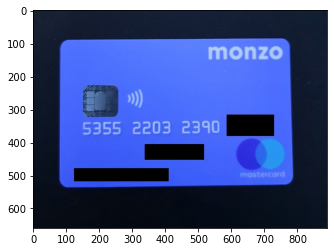

In [11]:
image = cv2.imread('test_card.jpg')
plt.imshow( image , cmap = 'gray' )
plt.show()

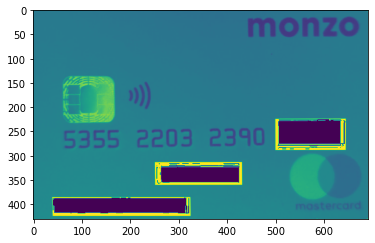

In [12]:
image = doc_Scan(image)
plt.imshow( image )
plt.show()

We now need to extract the credit card number region. If you looked at the code in the above example we are always re-sizing our extracted credit card image to a size of 640 x 403. The odd choice of 403 was chosen because 640:403 is the actual ratio of a credit card. We are trying to maintain as accurate as possible the length and width dimensions so that we don't necessarily warp the image too much.

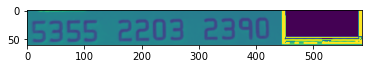

In [13]:
region = [(55, 230), (640, 290)]

top_left_y = region[0][1]
bottom_right_y = region[1][1]
top_left_x = region[0][0]
bottom_right_x = region[1][0]

# Extracting the area were the credit numbers are located
roi = image[top_left_y:bottom_right_y, top_left_x:bottom_right_x]
cv2.imwrite("credit_card_extracted_digits.jpg", roi)
plt.imshow( roi )
plt.show()